<a href="https://colab.research.google.com/github/yurifillippo/datascience/blob/master/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn - O que é?

O churn, também conhecido como churn rate, é um indicador que mede o índice de evasão dos clientes , ou seja, a taxa de cancelamento.

Para calcular o churn, basta dividir a quantidade de clientes que perdeu até o final do período pelo total de clientes que iniciaram. Exemplo: se você perdeu 10 clientes de 100 = 10% de churn rate

Ele é importante porque, se sua empresa está perdendo muitos clientes, ou seja, está com o churn alto, é sinal de que há algum problema que precisa ser melhorado.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
  
# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)
 
# ver as 5 primeiras entradas
print("Entradas: {}".format(df.shape[0]))
print("Variáveis: {}".format(df.shape[1]))
df.head()

Entradas: 7043
Variáveis: 21


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Ao realizar a primeira análise com as 5 primeiras entradas, identificamos que temos vários padrões de entradas, algumas números, outras strings, que serão trabalhadas ao longo do projeto, a variável algo é a "Churn" com entradas "No" e "Yes".

O dataset original possui 21 variáveis e 7043 entradas.

Iremos abaixo analisar a quantidade de valores nulos o dataset apresenta, junto com os tipos de variáveis, para iniciarmos os tratamentos dos dados.

In [ ]:
#Valores ausentes por variável
print("Ver valores ausentes:\n\n{}".format(df.isnull().sum()))
 
#Tipos de variáveis
print("\n\n Ver tipos de variáveis:\n\n{}".format(df.dtypes))

Ver valores ausentes:

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


 Ver tipos de variáveis:

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     objec

Ao analisar cada variável separadamente, seguiremos com as seguintes ações:
- Excluir variável **customerID**, a mesma não tem influência no modelo de machine learning;

- A variável **TotalCharges** se apresenta no dataset como string, porém, o correto seria float;

- Variáveis: gender, Partner, Dependents, PhoneService, MultipleLines, InternetService,	OnlineSecurity,	OnlineBackup,	DeviceProtection,	TechSupport,	StreamingTV,	StreamingMovies,	Contract,	PaperlessBilling e PaymentMethod, analisar valores únicos e codificar para valores numéricos. 	

In [ ]:
#Excluir variável customerID
df.drop('customerID', axis=1, inplace=True)
 
#Alterar valores string vazios na variável TotalCharges
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'].str.strip()
 
#Retornar o conjunto de dados como DataFrame
pd.DataFrame(df)
 
#Alterar tipo da variável TotalCharges
df['TotalCharges'] = df['TotalCharges'].astype(float)
 
#Verificar quantidade de entradas vazias na variável TotalCharges
print("Entradas vazias: {}".format(df['TotalCharges'].isnull().sum()))

Entradas vazias: 11


>  Com o tratamento da variável **TotalCharges** verificamos que temos 11 entradas vazias, onde iremos substituir pela mediana, e iniciaremos as conversões para codificações numéricas das demais.



In [ ]:
#Substituir valores vazios da variável TotalCharges pela mediana
medianTotalCharges = df['TotalCharges'].median()
df['TotalCharges'].fillna(medianTotalCharges, inplace=True)
 
#Verificar se ainda possui entradas vazias
print("Entradas vazias: {}".format(df['TotalCharges'].isnull().sum()))

Entradas vazias: 0


Agora que substituimos as entradas em nulas pela mediana, vamos separar as variáveis pelas que contém:
  * Entradas binárias
  * Entradas numéricas
  * Entradas categóricas

E transformaremos as categóricas utilizando a técnica de Encoding, onde o objetivo é aumentar a quantidade de feactures com informações binárias, desta forma o modelo de machine learning trará um melhor resultado.

In [ ]:
#Selecionar variáveis com valores binários
var_bin = df.nunique()[df.nunique() == 2].keys().tolist()
 
#Selecionar variáveis de valores númericos, e retirar variáveis que estão em var_bin
num_var = [col for col in df.select_dtypes(['int', 'float']).columns.tolist() if col not in var_bin]
 
#Selecionar variáveis de valores string
cat_var = [col for col in df.columns.tolist() if col not in var_bin + num_var]
 
# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in var_bin:
  df[i] = le.fit_transform(df[i])
 
# Encoding para colunas categóricas com múltiplas classes
df = pd.get_dummies(df, columns=cat_var)
 
#Ver entradas do dataset
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


Após realizar o pré processamento dos dados, abaixo teremos uma análise estatística dos dados númericos:
>>> 

In [ ]:
#Análise estatística das variáveis que representam valores no dataset
df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2281.916928
std,24.559481,30.090047,2265.270398
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


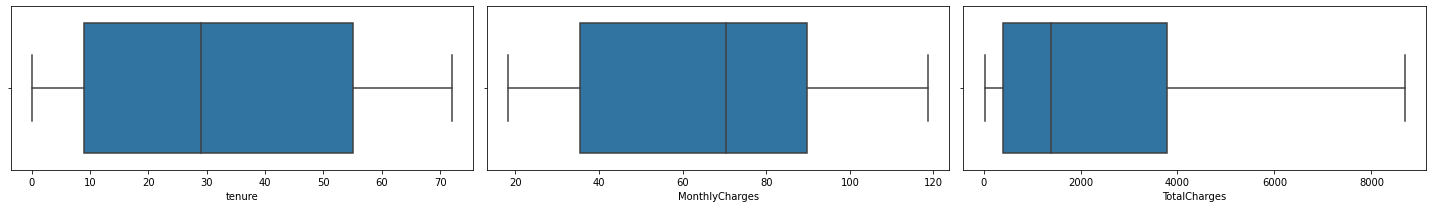

In [ ]:
#Plotar boxplot das variáveis númericas
fig, ax = plt.subplots(nrows=1,  ncols=3 ,figsize=(20,3))
sns.boxplot(df['tenure'], ax=ax[0])
sns.boxplot(df['MonthlyCharges'], ax=ax[1])
sns.boxplot(df['TotalCharges'], ax=ax[2])
plt.tight_layout()

>Conforme podemos ver acima, o dataset apresenta variáveis númericas sem outliers, o que descarta tratamentos sobre este tema.

  Informações sobre as variáveis:

  * **tenure** : representa a quantidade de meses que o cliente ficou ativo utilizando algum serviço;

  * **MonthlyCharges**: valor mensal pago pelo cliente;

  * **TotalCharges**: valor total pago pelo cliente durante sua assinatura


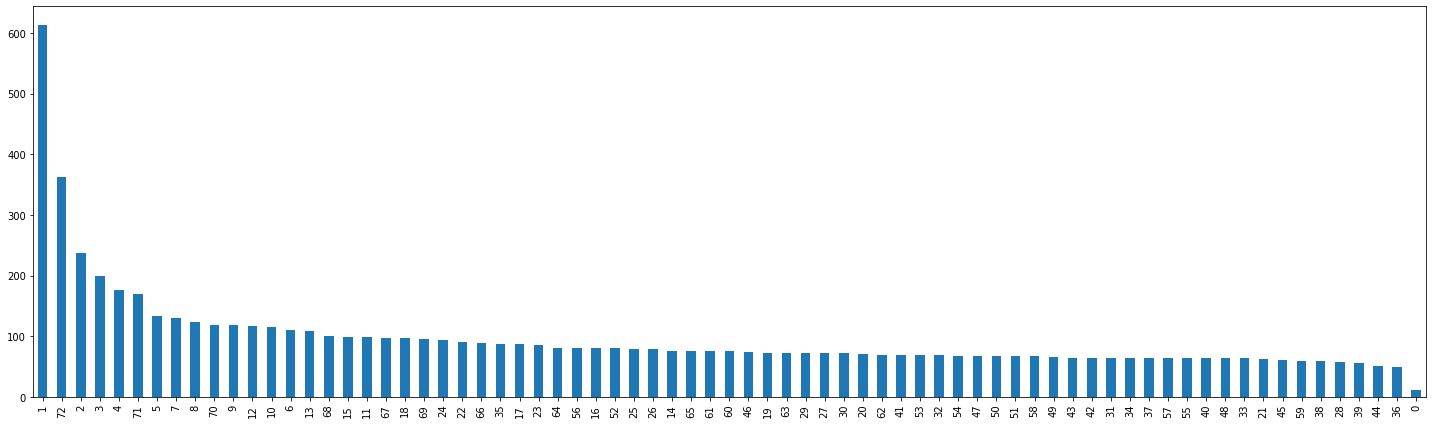

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
df['tenure'].value_counts().plot(kind='bar', ax=ax)
plt.tight_layout()

Com o gráfico acima podemos identificar que há um alto índice de clientes que tiveram os serviços contratados por apenas 1 mês, e ao mesmo tempo, o segundo maior valor, são de clientes que tiveram os serviços contratados por 72 meses.

Abaixo criei categorias para os valores pagos pelos clientes para buscar identificar a quantidade de cliente por faixa de valor.

In [ ]:
#Criar dicionárioup
df_fp = {'faixa_preco': ("0 a 25", "26 a 50", "51 a 75", "76 a 100", "> 101"),
         'qtd_clientes':( )}

#Criar lista para receber valores de quantidades
lista = []
lista.append(df.loc[df['MonthlyCharges'] <= 25].count()[0])
lista.append(df.loc[(df['MonthlyCharges'] > 25) & (df['MonthlyCharges'] <= 50)].count()[0])
lista.append(df.loc[(df['MonthlyCharges'] > 50) & (df['MonthlyCharges'] <= 75)].count()[0])
lista.append(df.loc[(df['MonthlyCharges'] > 75) & (df['MonthlyCharges'] <= 100)].count()[0])
lista.append(df.loc[df['MonthlyCharges'] > 100].count()[0])

#Criar dataframe
df_fp['qtd_clientes'] = lista
df_fp = pd.DataFrame.from_dict(df_fp)

#Verificar quantidade de valores 
df_fp['qtd_clientes'].sum()

7043

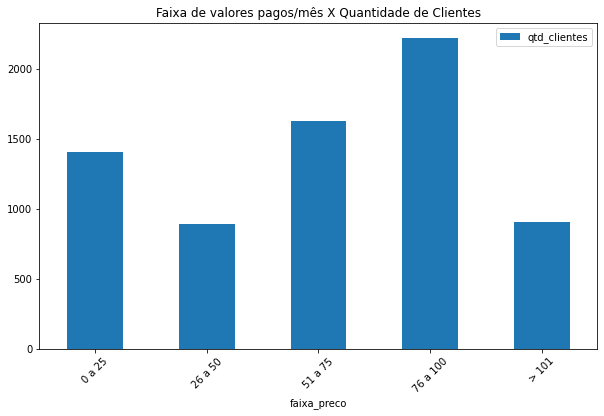

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
 
df_fp.plot(kind="bar",x='faixa_preco', y='qtd_clientes', ax=ax)
ax.set_title('Faixa de valores pagos/mês X Quantidade de Clientes')
ax.tick_params(axis='x', labelrotation=45 )

* Com o gráfico acima, temos a informação que a maior concentração de clientes (2218 clientes) pagam valores superiores a 75.00 e inferiores a 100.00

* A segunda maior classe (1624 clientes) pagam valores mensais acima de 50.00 e abaixo de 75.00

* A menor parte dos clientes (893 clientes) pagam valores de 26.00 a 50.00

 0 = NÃO
 1 = SIM


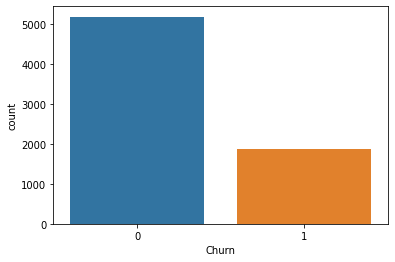

In [ ]:
#Balanceamento dos dados na variável alvo Churn
sns.countplot(df['Churn'])

print(" 0 = NÃO\n 1 = SIM")

Com as informações sobre o balanceamento do dataset, temos dados completamente desbalanceados, o que nos traria um modelo com uma maior acertividade em informar clientes que não estariam dentro do Churn, e as informações mais valiosas que seriam possíveis clientes que estariam dentro do Churn, teríamos uma precisão menor.

Abaixo iremos analisar a correlação entre as variáveis, porém, com dois datasets, um onde a variável alvo "Churn" é 0=Não e outra com valores 1=Sim

In [ ]:
#Dataset com Churn == 0
df_churn0 = df.loc[df['Churn'] == 0]
#Dataset com Churn == 1
df_churn1 = df.loc[df['Churn'] == 1]
#Definir correlação para Churn == 0
corr0 = df_churn0.corr()
#Definir correlação para Churn == 1
corr1 = df_churn1.corr()

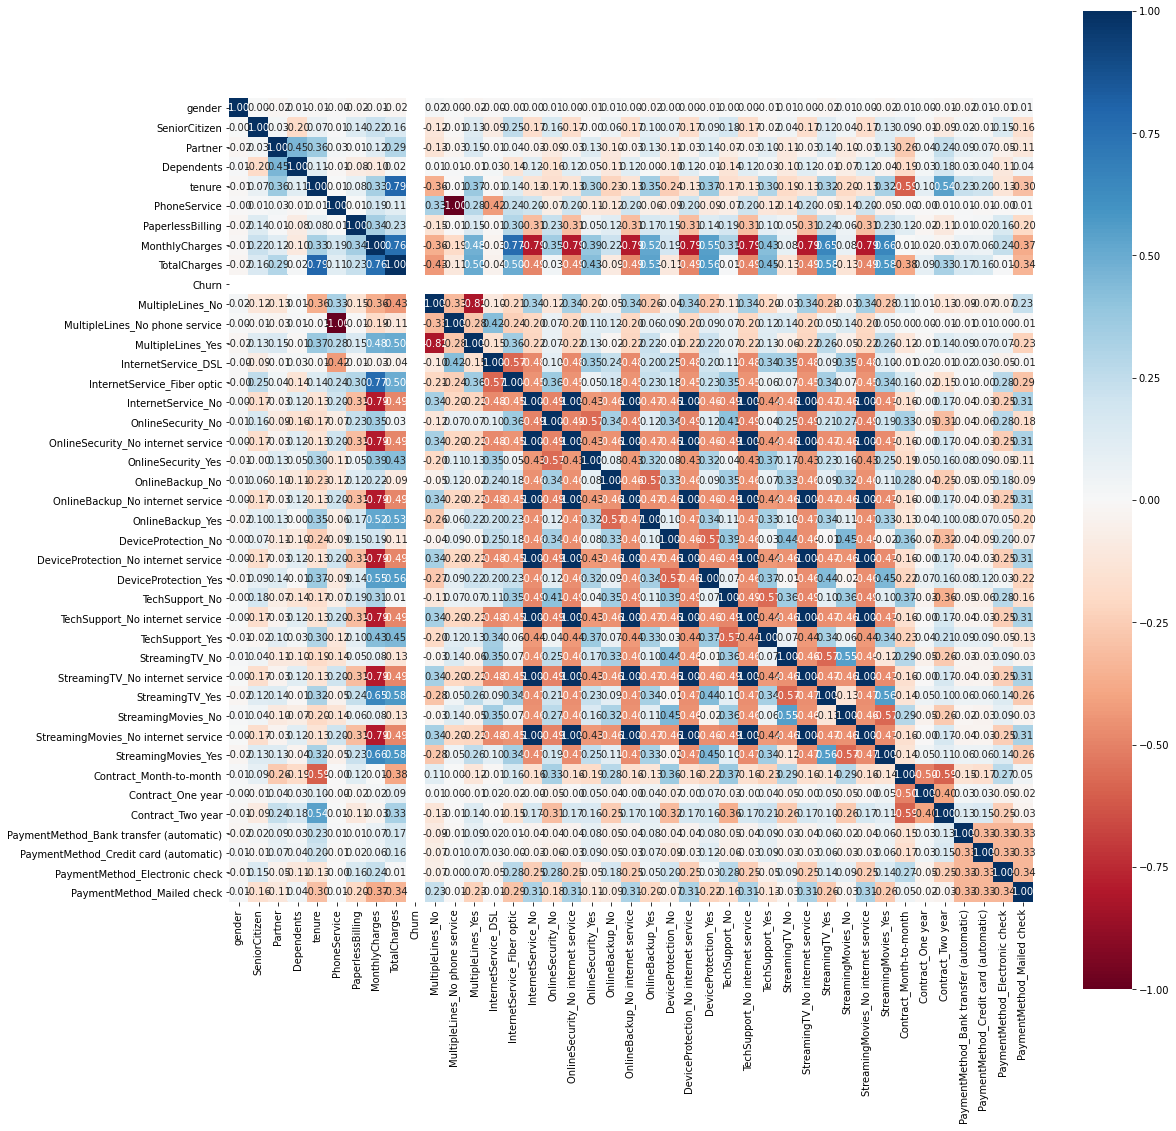

In [ ]:
#Plotar figure
fig, ax = plt.subplots(figsize=(18,18))

#Plotar heatmap de correlações
sns.heatmap(corr0, cmap='RdBu', fmt='.2f', square=True, linecolor='white', annot=True, ax=ax);

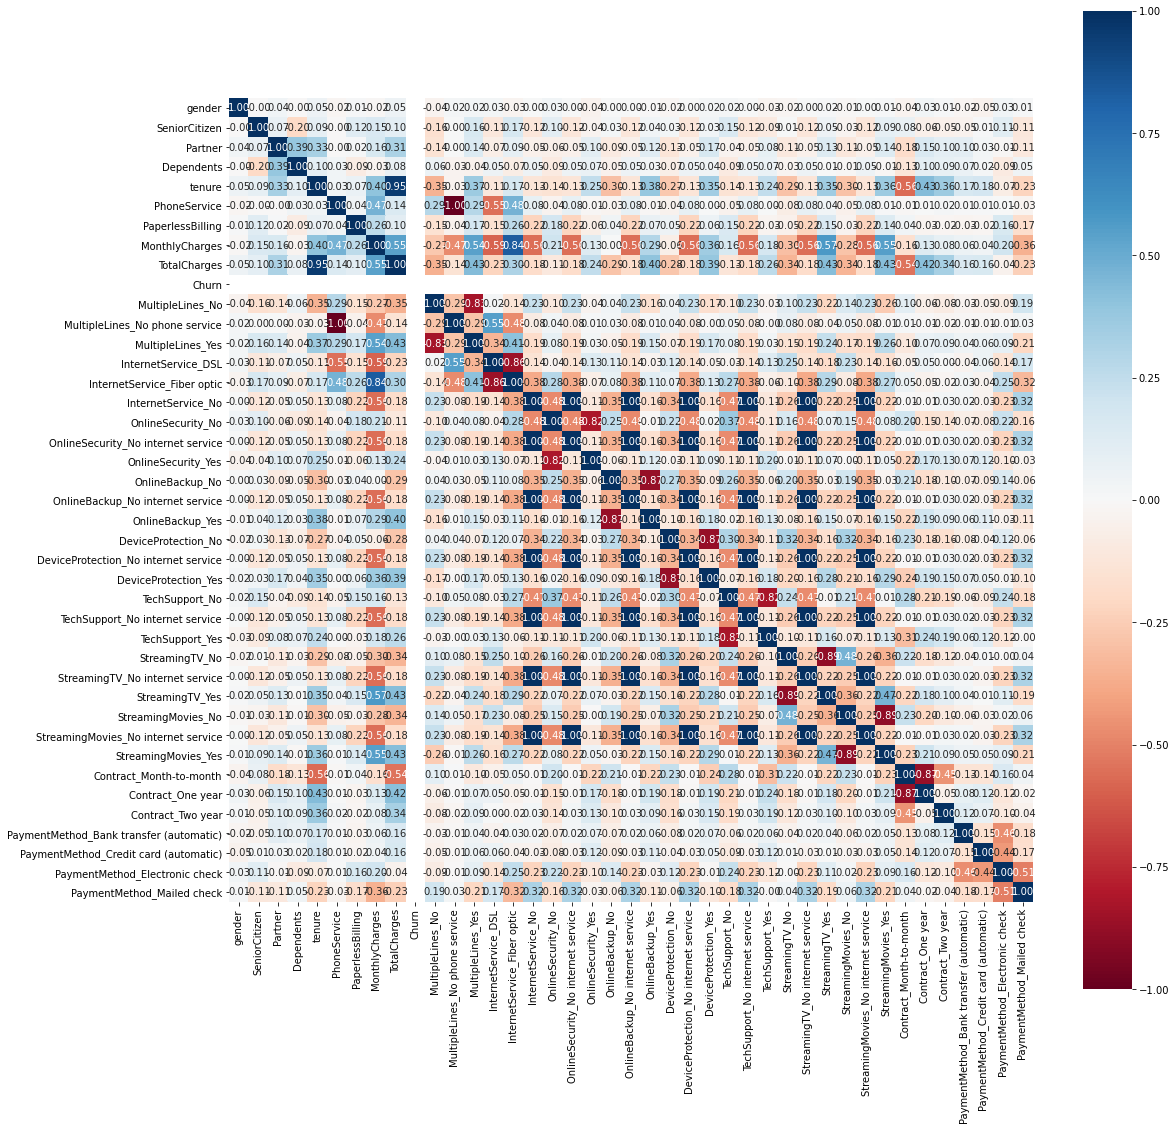

In [ ]:
#Plotar figure
fig, ax = plt.subplots(figsize=(18,18))
 
#Plotar heatmap de correlações
sns.heatmap(corr1, cmap='RdBu', fmt='.2f', square=True, linecolor='white', annot=True, ax=ax);

Podemos identificar que algumas variáveis tem uma correlação mais positiva no caso de clientes que não aderem mais ao serviço, como por exemplo MonthlyCharges. No dataset com Churn == 0 temos mais correlações com tendências negativas, e o segundo dataset, mais correlações mais voltadas para o positivo, o que indica comportamentos diferentes entre os dois grupos.

# Modelo de Machine Learning

Na criação do modelo de machine learning, iremos utilizar a técnica de Under Sampling para balancear os dados com três modelos diferentes de machine learning:

* Regressão Logística
* Decision Trees
* XGBoost

Para identificar o melhor modelo para os dados, utilizaremos também a técnica de cross validation, e após a escolha do modelo, uma otimização dos hiperparâmetros.

Buscaremos uma melhor performance com a métrica de Recall, que nós tras a formula: True Positivo / True Positivo + False Negativo

Iniciaremos dividindo o dataset entre treino e teste:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


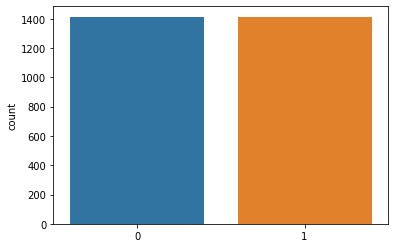

In [ ]:
#Separar variável alvo
X = df.drop('Churn', axis=1)
y = df['Churn']

# dividir os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y)

#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

#Balanceamento dos dados utilizando Under Sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

#Verificar balanceamento dos dados
sns.countplot(y_rus);

In [ ]:
#Instanciar modelos
modellogistic = LogisticRegression()
modeltrees = DecisionTreeClassifier()
modelxgboost = XGBClassifier()

#Cross-validation
scoremodellogistic = cross_val_score(modellogistic, X_rus, y_rus, cv=5, scoring='recall', )
scoremodeltrees = cross_val_score(modeltrees, X_rus, y_rus, cv=5, scoring='recall')
scoremodelxgboost = cross_val_score(modelxgboost, X_rus, y_rus, cv=5, scoring='recall');

print("\n\nRecall modelo de Regressão Logística: {}".format(scoremodellogistic.mean()))
print("Recall modelo de Árvore de Decisão: {}".format(scoremodeltrees.mean()))
print("Recall modelo XGBoost: {}".format(scoremodelxgboost.mean()))



Recall modelo de Regressão Logística: 0.7984637746535348
Recall modelo de Árvore de Decisão: 0.6775079567952285
Recall modelo XGBoost: 0.8012730872365486


>Após aplicarmos a técnica de cross validation para identificarmos o melhor modelo de machine learning, conseguimos concluir que o melhor recall foi do modelo XGBoost com uma média de .8146 sem hiperparâmetros.

>Agora com nosso modelo escolhido, iremos buscar por melhores parâmetros a fim de alcançar um recall de no mínimo 92%

In [ ]:
xgb = XGBClassifier()

#Criar dicionário com os parâmetros:
parameters = {
    'max_depth': [1,2,3,6,9,11,15],
    }

clf = GridSearchCV(xgb, parameters, scoring="recall", n_jobs=1)
clf.fit(X_rus, y_rus)

# ver resultados
print("Melhor: {} para {}".format(clf.best_score_, clf.best_params_))

Melhor: 0.8090569631356038 para {'max_depth': 1}


In [ ]:
xgb = XGBClassifier(max_depth=1)

#Criar dicionário com os parâmetros:
parameters = {
    'learning_rate': [0.001, 0.002, 0.003, 0.004],
    }

clf = GridSearchCV(xgb, parameters, scoring="recall", n_jobs=1)
clf.fit(X_rus, y_rus)

# ver resultados
print("Melhor: {} para {}".format(clf.best_score_, clf.best_params_))

Melhor: 0.8847204470841792 para {'learning_rate': 0.001}


In [ ]:
xgb = XGBClassifier(max_depth=1, learning_rate=0.001)

#Criar dicionário com os parâmetros:
parameters = {
    'n_estimators':range(0,100,1),
    }

clf = GridSearchCV(xgb, parameters, scoring="recall",  n_jobs=1)
clf.fit(X_rus, y_rus)

# ver resultados
print("Melhor: {} para {}".format(clf.best_score_, clf.best_params_))

Melhor: 0.8847204470841792 para {'n_estimators': 1}


In [ ]:
xgb = XGBClassifier(max_depth=1, learning_rate=0.001, n_estimators=1)

#Criar dicionário com os parâmetros:
parameters = {
    'gamma': [0,1,2,3,6,9],
    }

clf = GridSearchCV(xgb, parameters, scoring="recall", n_jobs=1)
clf.fit(X_rus, y_rus)

# ver resultados
print("Melhor: {} para {}".format(clf.best_score_, clf.best_params_))

Melhor: 0.8847204470841792 para {'gamma': 0}


In [ ]:
xgb = XGBClassifier(max_depth=1, learning_rate=0.001, n_estimators=1, gamma=0, min_child_weight=0)

#Criar dicionário com os parâmetros:
parameters = {
    'min_child_weight': [0,1,2,3,6,9],
    }

clf = GridSearchCV(xgb, parameters, scoring="recall", n_jobs=1)
clf.fit(X_rus, y_rus)

# ver resultados
print("Melhor: {} para {}".format(clf.best_score_, clf.best_params_))

Melhor: 0.8847204470841792 para {'min_child_weight': 0}


In [ ]:
#Instanciar modelo com parametros selecionados
model = XGBClassifier(max_depth=1, learning_rate=0.001, n_estimators=1, gamma=0, min_child_weight=0)

#Padronizar dados de treino
X_test = scaler.transform(X_test)

#Treinar modelo
model.fit(X_rus, y_rus)

#Realizar previsão
y_pred = model.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.59      0.72      1306
           1       0.43      0.89      0.58       455

    accuracy                           0.67      1761
   macro avg       0.68      0.74      0.65      1761
weighted avg       0.81      0.67      0.69      1761



## Instruções para o modelo de churn prediction

ENTENDA O SEU PROBLEMA
* Olhar o todo e delimitar o escopo do projeto
* Como a solução vai ser usada?
      >>> Algoritimo de machine learning para classificação
* Quais são as soluções já existentes?
      >>> XGBoost, Regressão Logística, Decision Trees 
* Qual abordagem usar?
      >>> Aprendizado Supervisionado
* Qual é a métrica de performance?
      >>> Acurácia (Previsões corretas/ total de previsões)
      >>> Precision (True Positivo / True Positivo + False Positivo)
      >>> Recall (True Positivo / True Positivo + False Negativo)
      >>> Matriz de Confusão
* Qual a performance mínima esperada para atingir o objetivo?
      >>> 92% de acurácia
* Liste as premissas básicas do projeto
      >>> As empresas buscam hoje um número negativo de Churn
      >>> Quantos clientes a empresa teria que realizar um trabalho com o Customer Sucess
      >>> Qual fator de maior relevância?

* Veja os serviços que outras empresas de Telecom oferecem 

EXPLORAR OS DADOS
* Estudar cada atributo e suas características:
    * Nome
    * Tipo
        * Categórica
        * Numérica
            * int
            * float
        * Estruturada
        * Não Estruturada
        * etc
    * % de valores ausentes
    * Ruído nos dados e tipo de ruído (outliers, estocásticos, erros de arredondamento)
    * Tipo de distribuição
        * Gaussiana
        * Uniforme
        * Logarítmica
        * etc
* Identificar a variável alvo (target)
* Visualizar os dados
* Estudar a correlação entre os dados
* Ver o balanceamento das classes
* Identificar as transformações que podem ser aplicadas
* Identificar os dados extras que podem ser úteis


PREPARAÇÃO DOS DADOS
* Limpeza dos Dados
    * Consertar ou remover outliers
    * Preencher os valores faltantes ou eliminar as linhas/colunas
        * Zero
        * Média
        * Mediana
        * Frequência
* Seleção de atributos
    * Eliminar os atributos (*features*) que não contêm informações úteis

* *Feature Engineering*
    * Discretizar variáveis contínuas
    * Decompor *features* (categóricas, data, tempo)
    * Aplicar transformações às variáveis
    * Agregar *features* para gerar novas
    
* *Feature Scaling*
    * Normalizar ou padronizar *features*

* Dividir entre treino, teste e validação

CONSTRUIR MODELO(S) DE MACHINE LEARNING
* Analisar as variáveis mais significativas para cada algoritmo
* *Hyperparameters Tuning* (se necessário)
* Uso de *cross-validation*
* Verificar o desempenho do(s) modelo(s) e considerar métodos *Ensemble*